Author: Ziyuan Li, 12211225
Date: 2024 Nov 25

This document is created as a report for SDM274, Sustech.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('wine.csv', header=None)
df.columns = ['Type', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',\
     'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# df.head(5)
filtered_df = df[df['Type'] != 3]
print(filtered_df.groupby('Type').size())

Type
1    59
2    71
dtype: int64


The data preprocessing for this assignment (assgn04) will be the same.

The raw data consists of rows, each representing information on a specific type of wine, separated by commas. Here, after reading the data in CSV format, we will organize the column types.

Next, we’ll create a new subset using pandas, dropping the wines with a type of 3 to facilitate further processing.

In the training and prediction part, we'll map the y into 1 and 0, which is different from assgn03.

In [7]:
y = filtered_df.iloc[:,0]
X = filtered_df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=3)


Mission Accomplished: Split the data into training and test sets, with the test set size set to 0.3. Specify a random seed to ensure the experiment is reproducible.

In [8]:
class LogisticRegression():

    def __init__(self, n_feature = 13, learning_rate = 1e-5, epochs = 100, tolerance = None, patience = 10):
        self.lr = learning_rate
        self.epochs = epochs
        # self.W = np.random.random(n_feature + 1)
        self.W = np.random.uniform(-0.01, 0.01, n_feature + 1)
        self.loss = []
        self.best_loss = np.inf
        self.tol = tolerance
        self.patience = patience
        
    def _linear_tf(self, X):
        return X @ self.W
    
    def _sigmoid(self, z):
        out = 1. / (1. + np.exp(-z))
        return out

    def _map_y(self, y):
        mapper = lambda y: 0 if y == 1 else 1
        return np.array([mapper(yi) for yi in y])

    def _predict_probability(self, X):
        z = self._linear_tf(X)
        return self._sigmoid(z)

    def _cross_entropy_loss(self, y, y_pred):
        epsilon = 1e-8
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1-y) * np.log(1-y_pred + epsilon))
        return loss
    
    def _gradient(self, X, y, y_pred):
        # if-else for single sample and multiple samples. This is a pretty naive solution but it works in our case.
        if isinstance(y, np.ndarray):
            return -(y - y_pred) @ X / y.size
        else:
            return -(y - y_pred) * X / y.size

    
    def _preprocess_data(self, X):
        m, n = X.shape
        X_ = np.empty([m, n+1])
        X_[:, 0] = 1
        X_[:, 1:] = X

        return X_

    def BGD(self, X_train, y):

        X_train_bar = self._preprocess_data(X_train)
        y = self._map_y(y)
        epoch_no_improve = 0

        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(X_train_bar.shape[0])
            X_train_bar = X_train_bar[shuffle_index]
            y = y[shuffle_index]

            y_pred = self._predict_probability(X_train_bar)

            # why is loss here valid? 
            # loss generally should be a scalar. In our previous example, the loss was calculated for each data feature, but here in the logistic func, it is different.
            loss = self._cross_entropy_loss(y, y_pred)
            self.loss.append(loss)

            gradient = self._gradient(X_train_bar, y, y_pred)
            self.W -= self.lr * gradient

            if self.tol is not None:
                if loss < self.best_loss - self.tol and loss != 0:
                    # the case where the new loss is good enough
                    # i.e. change of loss is bigger than the tolerance
                    self.best_loss = loss # we update the best loss
                    epoch_no_improve = 0
                elif np.abs(loss - self.best_loss) < self.tol:
                    epoch_no_improve += 1
                    if epoch_no_improve == self.patience:
                        print(f'Early stopping at epoch {epoch}')
                        return        


    def SGD(self, X_train, y):
        X_train_bar = self._preprocess_data(X_train)
        y = self._map_y(y)
        epoch_no_improve = 0

        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(X_train_bar.shape[0])
            X_train_bar = X_train_bar[shuffle_index]
            y = y[shuffle_index]
            # we have this part unchanged
            
            for i in range(X_train_bar.shape[0]):
                x_bar = X_train_bar[i]
                y_pred = self._predict_probability(x_bar)
                loss = self._cross_entropy_loss(y, y_pred)
                self.loss.append(loss)
                # x_bar is one sample here
                gradient = self._gradient(x_bar, y[i], y_pred)
                self.W -= self.lr * gradient

                # update-based early stopping
                if self.tol is not None:
                    if loss < self.best_loss - self.tol and loss != 0:
                        self.best_loss = loss
                        epoch_no_improve = 0
                    elif np.abs(loss - self.best_loss) < self.tol:
                        epoch_no_improve += 1
                        if epoch_no_improve == self.patience:
                            print(f'Early stopping at epoch {epoch}')
                            return

    def MBGD(self, X_train, y, batch_size = 16):
        X_train_bar = self._preprocess_data(X_train)
        y = self._map_y(y)
        epoch_no_improve = 0

        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(X_train_bar.shape[0])
            X_train_bar = X_train_bar[shuffle_index]
            y = y[shuffle_index]
            # we have this part unchanged
            
            for i in range(0, X_train_bar.shape[0], batch_size): 
                # Here, Python's slicing mechanism will automatically handle out-of-bounds cases. 
                # If the size is not divisible, the size of the last batch will be smaller than batch_size.
                x_bar = X_train_bar[i:i+batch_size]
                y_slice = y[i:i+batch_size]
                y_pred = self._predict_probability(x_bar)
                loss = self._cross_entropy_loss(y_slice, y_pred)
                self.loss.append(loss)
                # x_bar is one sample here
                gradient = self._gradient(x_bar, y[i:i+batch_size], y_pred)
                self.W -= self.lr * gradient

                # update-based early stopping
                if self.tol is not None:
                    if loss < self.best_loss - self.tol and loss != 0:
                        self.best_loss = loss
                        epoch_no_improve = 0
                    elif np.abs(loss - self.best_loss) < self.tol:
                        epoch_no_improve += 1
                        if epoch_no_improve == self.patience:
                            print(f'Early stopping at epoch {epoch}')
                            return
    
    def predict(self, X):
        X = self._preprocess_data(X)
        y_pred = self._predict_probability(X)
        return np.where(y_pred >= 0.5, 1, 0)
    
    def batch_cross_entropy_loss(self, y, y_pred):
        loss = np.where( y == y_pred, 0, 1)
        return loss



    

Perceptron and Logistic Regression differ in terms of their loss functions and optimization techniques. 

Perceptron uses a loss function focused on maximizing the margin of correct classification, specifically updating only when the model misclassifies a sample. This implies that Perceptron only updates its weights when it encounters misclassified points. 

Logistic Regression, however, uses a cross-entropy or log-loss function, continuously optimizing by maximizing the likelihood of the observed labels through techniques like gradient descent. Unlike Perceptron, Logistic Regression updates its weights for every sample based on its probability estimate, regardless of whether it correctly classifies the sample or not.

Another crucial difference is their behavior in relation to the linear separability of the data.

Perceptron is designed under the assumption that data is linearly separable; it performs well in cases where a clean linear boundary exists between classes. However, when the data is not linearly separable, the Perceptron algorithm struggles and may not converge, leading to oscillations between misclassified points. 

Logistic Regression, on the other hand, does not require strict linear separability. Its probabilistic framework allows it to fit a decision boundary that can still offer meaningful class probabilities even in cases where the data is not perfectly separable, providing a more stable solution in practice.

Finally, Logistic Regression is better in its interpretability. 

Its probabilistic output allows users to not only make predictions but also to gauge the model’s confidence in those predictions, making it a more explainable model compared to the Perceptron. This makes Logistic Regression a better fit for situations where it is essential to interpret the certainty or risk of predictions, as well as for applications where prediction probabilities are used directly, such as in risk assessment or anomaly detection.

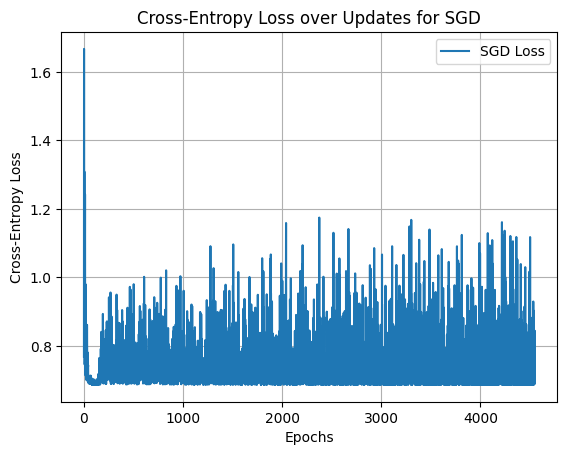

The final loss is 0.8247856650720347
Average loss after 1000 updates is 0.751201423976472


In [9]:
# we need some conversion between numpy and pandas
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train


# update_based loss calculation
model_SGD = LogisticRegression()
model_SGD.lr =1e-7
model_SGD.epochs = 50
model_SGD.tol = 1e-6
model_SGD.SGD(X_train, y_train)

# separating the plotting func with the class. More versatile.
plt.plot(model_SGD.loss, label='SGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss over Updates for SGD')
plt.legend()
plt.grid()
plt.show()

print(f'The final loss is {model_SGD.loss[-1]}')
avg_loss = np.mean(model_SGD.loss[1000:])
print(f"Average loss after 1000 updates is {avg_loss}")


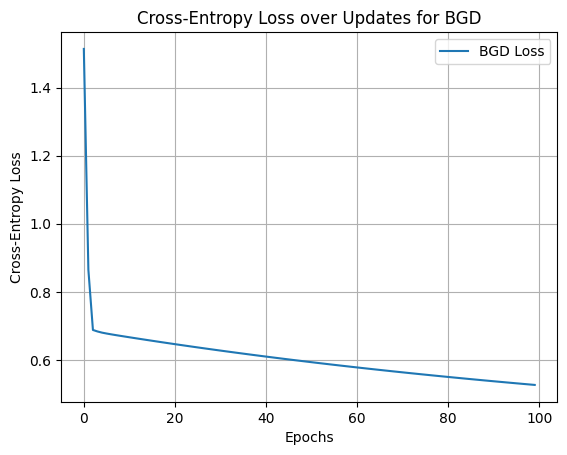

The final loss is 0.5263262450839876
Average loss for last 30 epochs is 0.5442434935366439


In [10]:
# we need some conversion between numpy and pandas
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

model_BGD = LogisticRegression()
model_BGD.lr = 1e-5
model_BGD.epochs = 100
model_BGD.tol = 1e-7
model_BGD.BGD(X_train, y_train)

plt.plot(model_BGD.loss, label='BGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss over Updates for BGD')
plt.legend()
plt.grid()
plt.show()

print(f'The final loss is {model_BGD.loss[-1]}')
avg_loss_bgd = np.mean(model_BGD.loss[-30:])
print(f"Average loss for last 30 epochs is {avg_loss_bgd}")


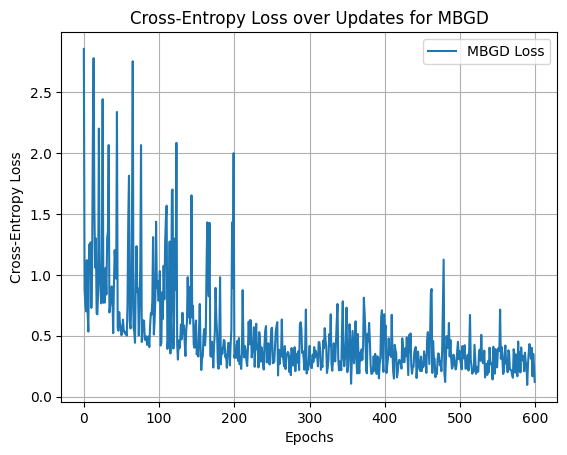

The final loss is 0.12174021687249213
Average loss for last 30 batch is 0.28758373603661036


In [11]:
# we need some conversion between numpy and pandas
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

model_MBGD = LogisticRegression()
model_MBGD.lr = 2e-5
model_MBGD.epochs = 100
model_MBGD.tol = 1e-7
model_MBGD.MBGD(X_train, y_train, batch_size = 16)

plt.plot(model_MBGD.loss, label='MBGD Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss over Updates for MBGD')
plt.legend()
plt.grid()
plt.show()

print(f'The final loss is {model_MBGD.loss[-1]}')
avg_loss_mbgd = np.mean(model_MBGD.loss[-30:])
print(f"Average loss for last 30 batch is {avg_loss_mbgd}")

The training strcture here is mostly the same as our perceptron.

But, the training process is a little bit different, below are some empirical observations

First, the logistic model can be very picky about learning rate, especially in the MBGD training.
Taking batch size = 16, the optimal learning rate falls between 1e-5 to 5e-5, any lr out of this range would be difficult to train.

Second, the final result of the training is often not as good as the perceptron. The F1-score below (approx 0.92) is the best result after many times of training and optimizing hyperparameters, and exclusive to the MBGD approach. In BGD training and SGD training, the F1 score is often about 0.8.

Third, the precision of BGD and SGD are often higher than the recall. The recall often stays at about 0.7 while the precision. Overall the logistic model is more conservative.

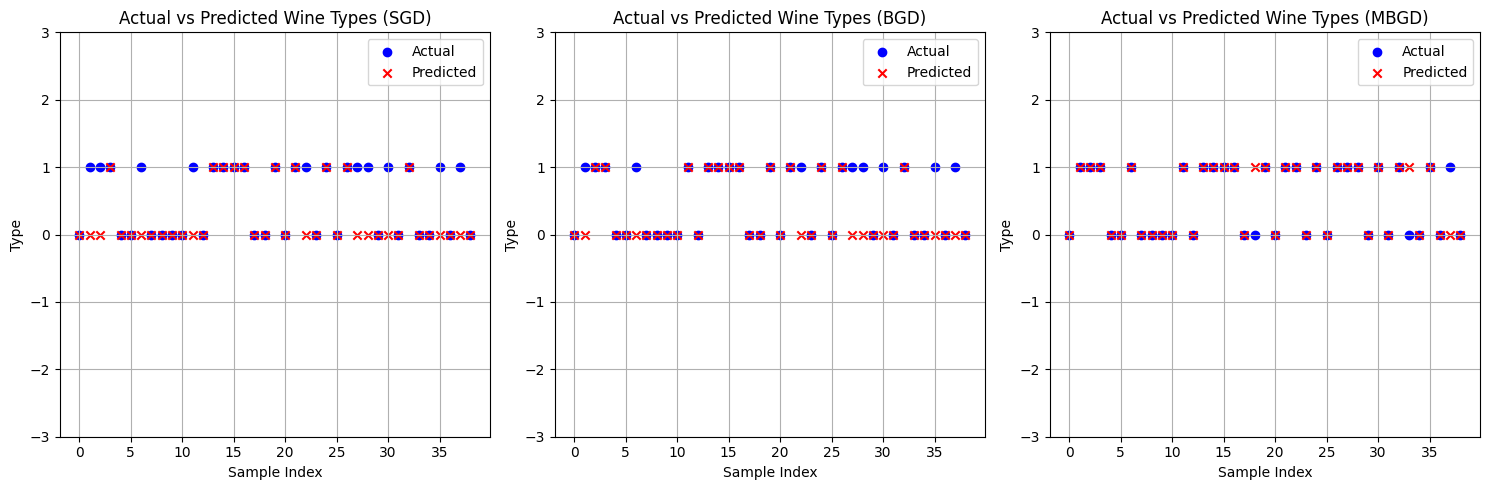

In [12]:
# Convert y_test to numpy array if it's not already
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Map y_test to binary values
mapper = lambda y: 0 if y == 1 else 1
y_mapped = np.array([mapper(yi) for yi in y_test])

# Predict the test set for all three models
y_pred_sgd = model_SGD.predict(X_test)
y_pred_bgd = model_BGD.predict(X_test)
y_pred_mbgd = model_MBGD.predict(X_test)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot for SGD
plt.subplot(1, 3, 1)
plt.scatter(range(len(y_mapped)), y_mapped, color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred_sgd, color='red', label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Type')
plt.ylim(-3, 3)
plt.title('Actual vs Predicted Wine Types (SGD)')
plt.legend()
plt.grid(True)

# Plot for BGD
plt.subplot(1, 3, 2)
plt.scatter(range(len(y_mapped)), y_mapped, color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred_bgd, color='red', label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Type')
plt.ylim(-3, 3)
plt.title('Actual vs Predicted Wine Types (BGD)')
plt.legend()
plt.grid(True)

# Plot for MBGD
plt.subplot(1, 3, 3)
plt.scatter(range(len(y_mapped)), y_mapped, color='blue', label='Actual')
plt.scatter(range(len(y_test)), y_pred_mbgd, color='red', label='Predicted', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Type')
plt.ylim(-3, 3)
plt.title('Actual vs Predicted Wine Types (MBGD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

A comparison of different approchs' predictions is shown above. Next we use metrics to evaluate them. 

In [8]:
def calculate_accuracy(y_actual, y_pred):

    correct_predictions = 0
    total_predictions = len(y_actual) # 其实y_actual和y_pred的长度是一样的

    for i in range(total_predictions):
        if y_actual[i] == y_pred[i]:
            correct_predictions += 1

    return correct_predictions / total_predictions

def calculate_recall(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_negative = 0

    for i in range(len(y_actual)):
        if y_actual[i] == positive_label:
            if y_pred[i] == positive_label:
                true_positive += 1
            else:
                false_negative += 1

    recall = true_positive / (true_positive + false_negative)
    # tp + fn 为真值的总数
    return recall

def calculate_precision(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_positive = 0

    for i in range(len(y_actual)):
        if y_pred[i] == positive_label:
            if y_actual[i] == positive_label:
                true_positive += 1
            else:
                false_positive += 1

    precision = true_positive / (true_positive + false_positive)
    # 在预测为正的情况下，有多少是真的正值
    # 如果模型过多地判定正值，那么recall会很高，但是precision会很低
    # 如果模型过多地判定负值，那么recall会很低，但是在判定为真值的样本里真值往往更多。（过于保守）
    
    return precision

def calculate_f1_score(y_actual, y_pred, positive_label=1):
    precision = calculate_precision(y_actual, y_pred, positive_label)
    recall = calculate_recall(y_actual, y_pred, positive_label)

    f1_score = 2 * precision * recall / (precision + recall)
    # 理想值是precision = 1, recall = 1.
    # 在两者数量相等的时候，f1_score比较高。
    return f1_score


# Calculate and compare the scores for three approaches
accuracy_sgd = calculate_accuracy(y_mapped, y_pred_sgd)
recall_sgd = calculate_recall(y_mapped, y_pred_sgd)
precision_sgd = calculate_precision(y_mapped, y_pred_sgd)
f1_score_sgd = calculate_f1_score(y_mapped, y_pred_sgd)

accuracy_bgd = calculate_accuracy(y_mapped, y_pred_bgd)
recall_bgd = calculate_recall(y_mapped, y_pred_bgd)
precision_bgd = calculate_precision(y_mapped, y_pred_bgd)
f1_score_bgd = calculate_f1_score(y_mapped, y_pred_bgd)

accuracy_mbgd = calculate_accuracy(y_mapped, y_pred_mbgd)
recall_mbgd = calculate_recall(y_mapped, y_pred_mbgd)
precision_mbgd = calculate_precision(y_mapped, y_pred_mbgd)
f1_score_mbgd = calculate_f1_score(y_mapped, y_pred_mbgd)

# Print the results in a sheet format
print(f"{'Approach':<10} {'Accuracy':<10} {'Recall':<10} {'Precision':<10} {'F1 Score':<10}")
print(f"{'-'*50}")
print(f"{'SGD':<10} {accuracy_sgd:<10.4f} {recall_sgd:<10.4f} {precision_sgd:<10.4f} {f1_score_sgd:<10.4f}")
print(f"{'BGD':<10} {accuracy_bgd:<10.4f} {recall_bgd:<10.4f} {precision_bgd:<10.4f} {f1_score_bgd:<10.4f}")
print(f"{'MBGD':<10} {accuracy_mbgd:<10.4f} {recall_mbgd:<10.4f} {precision_mbgd:<10.4f} {f1_score_mbgd:<10.4f}")


Approach   Accuracy   Recall     Precision  F1 Score  
--------------------------------------------------
SGD        0.8205     0.7000     0.9333     0.8000    
BGD        0.8205     0.7000     0.9333     0.8000    
MBGD       0.8205     0.7000     0.9333     0.8000    


Here MBGD achieves the best score.